# **California Housing Prices Prediction**




In [2]:
#importing necessary libraries that will be used in this projects.

#----------------- EDA Libraries-------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#-----------------------Data Sampling----------------------------------
from sklearn.model_selection import train_test_split

#------------------- Transformers and Data Pipelines------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer

#-----------------------Machine Learning Models------------------------
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#-----------------------Evaluation Metrices------------------------------
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
housing = pd.read_csv('housing.csv')
housing.head() #checking first five rows to get the idea of our data.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape #total number of rows and columns we have in our dataset.

(20640, 10)

In [5]:
#name of columns in the dataset , getting names of columns can solve spelling related 
#problem while EDA.
housing.columns 

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [6]:
#almost every column we have is numerical . but we have an exception ,ocean proximity
#column to check unqiue categories it holds.
housing["ocean_proximity"].unique() 

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

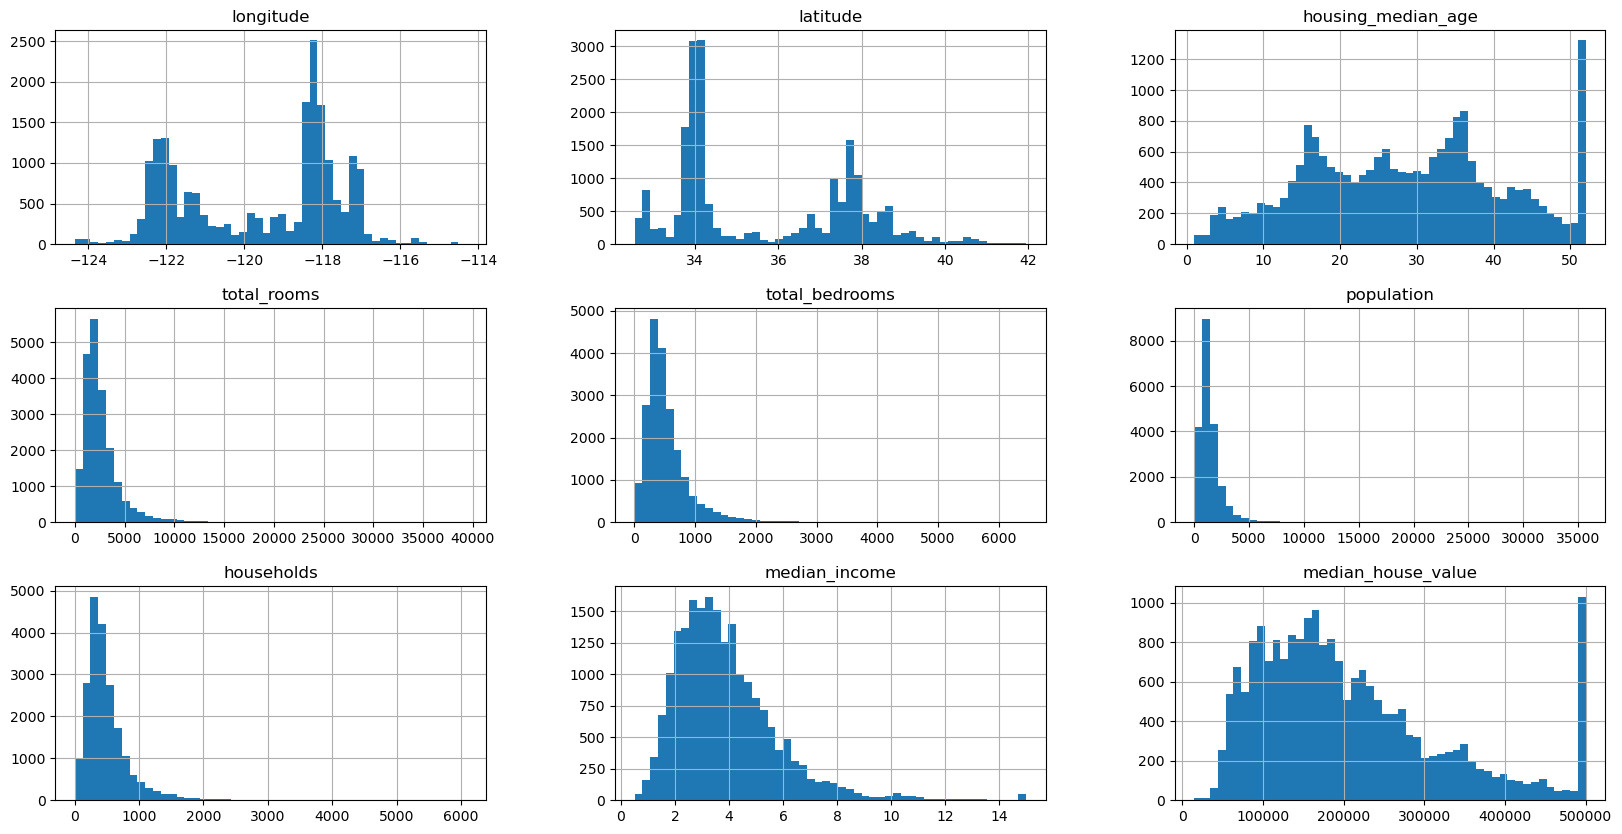

In [7]:
#lets do some exploratory data analysis get the idea how we going handle the data to machine 
# learning model.
housing.hist(bins=50,figsize=(20,10))
plt.show()



### Histogram of each numerical column to get understand the distribution of data.
`insights`
1. [housing median age , median house value], are capped at certain number. this includes every item greater than capped value , making the frequency of capped value bigger than any other in the data. 
2. [total rooms,total bedrooms,population,households,median income ] is `Rigth skewed` .

**note**<p style='color:tomato'> _this shows that our data has outliers and we need to handle them while making data preprocessing pipeline . we won't remove the outliers because we have only limited number of rows and we do not want to reduce our data size. so  we will use Standard scaler to scale our data.(standard scaling is unaffected by outliers__</p>

<Axes: xlabel='longitude', ylabel='latitude'>

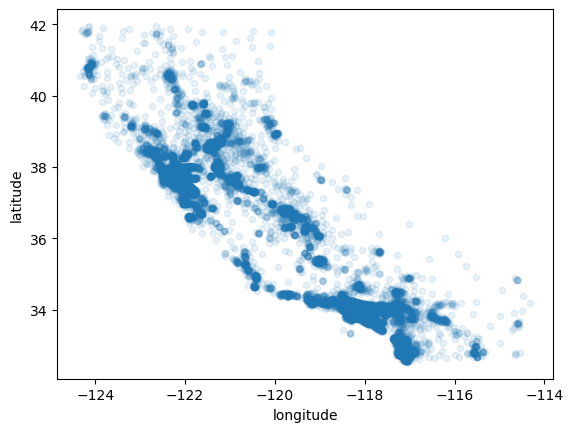

In [8]:
#these are the highly dense areas of california
housing.plot(kind='scatter',x="longitude", y="latitude",alpha=0.1)

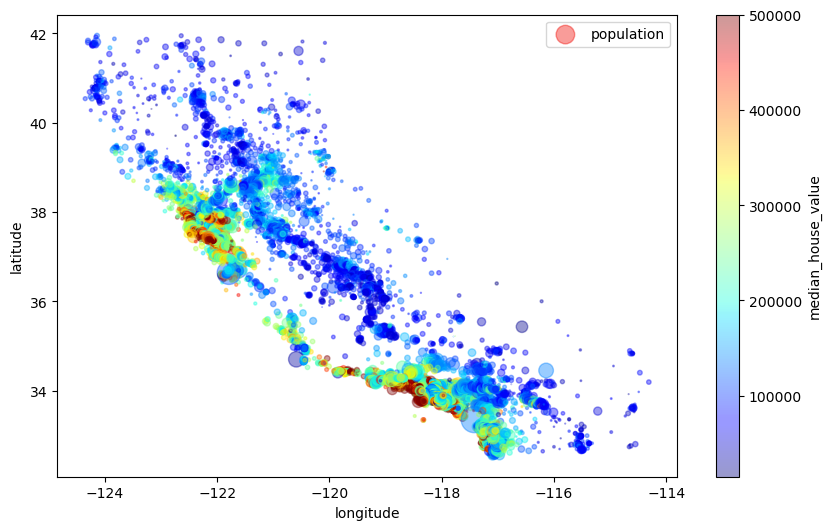

In [9]:
#To get a better visualization of population density and median house value of california .
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing["population"]/100,
            label="population",c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,
            figsize=(10,6))
plt.legend()
plt.show()

In [10]:
#Correlation is very useful method in case of continues values.and very useful in knowing linear dependency of label with other features
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

C:\Users\manna\AppData\Local\Temp\ipykernel_8208\1794343605.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

      INSIGTHS
      1. median house value is highly (68%) depends on median income
      2. other features such as total rooms , median age,latitude also affects house value.

# <span style='color:red'>Correlation </span>
<pre style ="background-color:Violet"><b>
The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation; for example, the median house value tends to go
up when the median income goes up. When the coefficient is close to –1, it means
that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north). Finally, coefficients close to zero mean that there is no
linear correlation</b>
</pre>

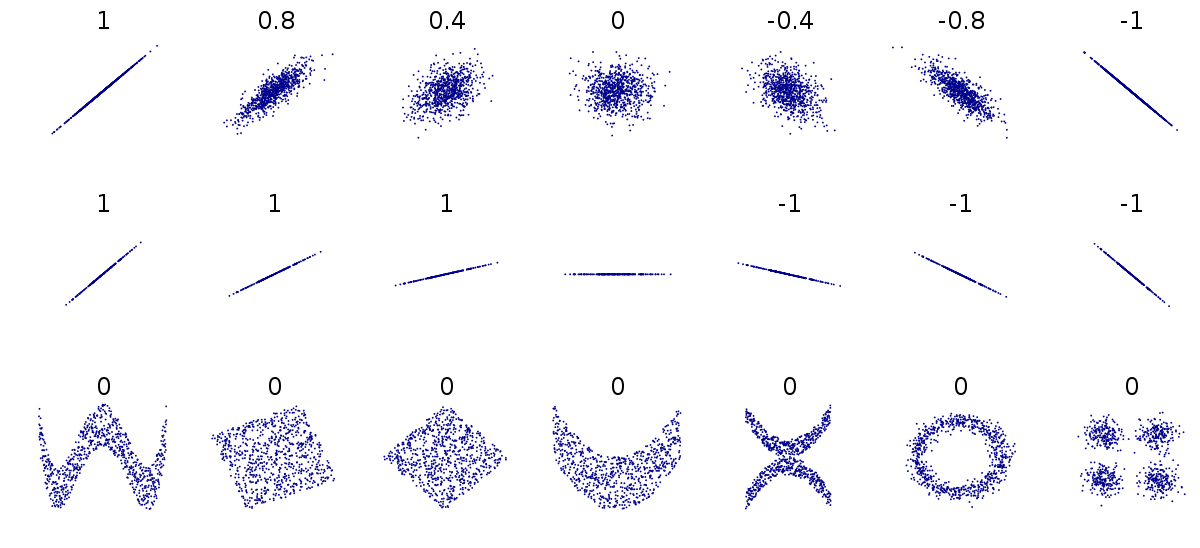
`Covariance`

`Correlation Coeficient`



$$cov_{x,y}=\frac{\sum(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$$
$$cov_{x,y}	=	\text {covariance between variable x and y}$$
$x_{i}	=	data value of x$

$y_{i}	=	\text {data value of y}$

$\bar{x}	=	\text {mean of x}$

$\bar{y}	=	\text {mean of y}$

$N	=	\text {number of data values}$

$r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$

$r	=	\text {correlation coefficient}$

$x_{i}	=	\text {values of the x-variable in a sample}$

$\bar{x}	=	\text {mean of the values of the x-variable}$

$y_{i}	=	\text{values of the y-variable in a sample}$

$\bar{y}	=\text	{mean of the values of the y-variable}$


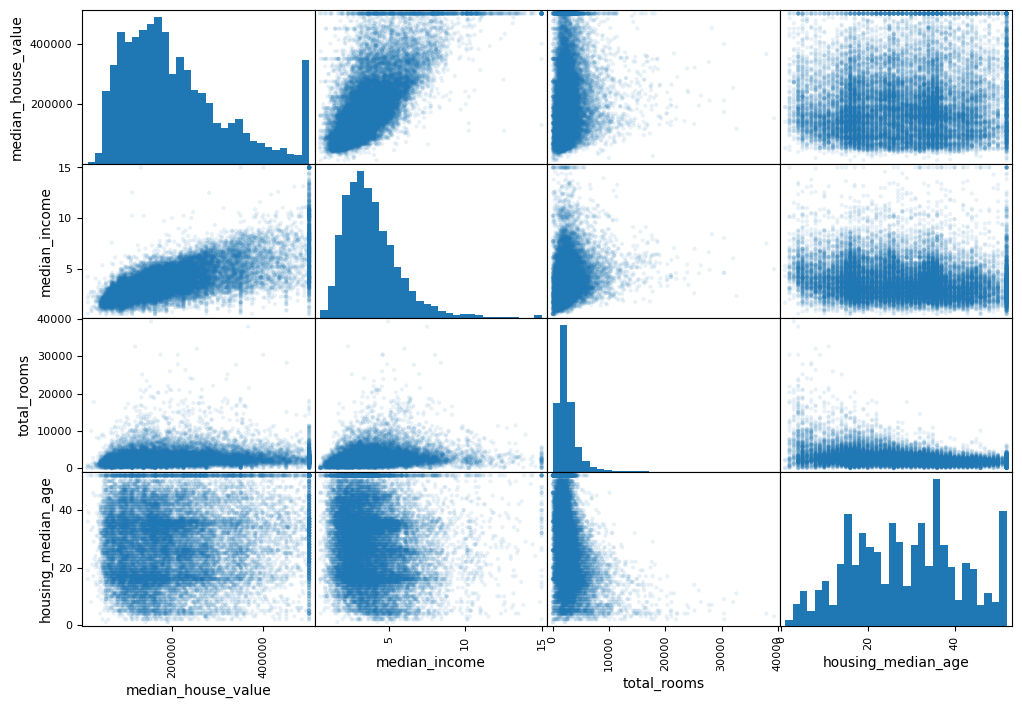

In [11]:
#Pandas’scatter_matrix function is used to plots every numerical attribute against every other numerical attribute
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], hist_kwds={"bins": 30}, alpha=0.1, figsize=(12, 8), marker='.')
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

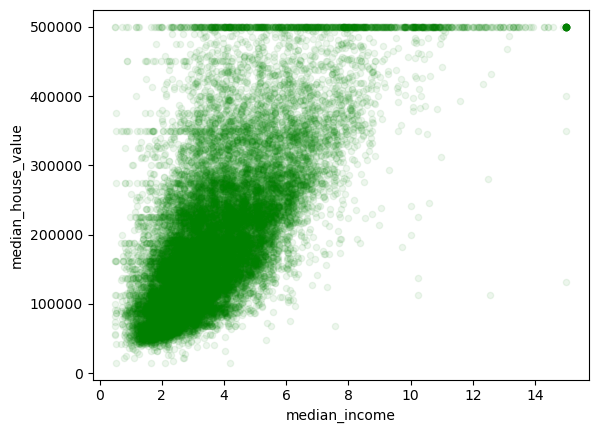

In [12]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.07,color='green')
#This plot reveals that the correlation is indeed very strong and you can
#clearly see the upward trend and the points are not too dispersed

<p style='color:gray'># The price cap is clearly visible as a horizontal line at 500,000, But this plot reveals other less obvious straight lines: a horizontal line around 450,000,another around 350,000,  and a few more below that.we will removethe corresponding rows to prevent  algorithms
from learning to reproduce these data quirks</p>

### Adding new features/attributes

In [13]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False,key=lambda x:abs(x))

C:\Users\manna\AppData\Local\Temp\ipykernel_8208\1022924202.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.688075
bedrooms_per_room          -0.255880
rooms_per_household         0.151948
latitude                   -0.144160
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
longitude                  -0.045967
population                 -0.024650
population_per_household   -0.023737
Name: median_house_value, dtype: float64

* <p style='background-color:DodgerBlue'>
The new bedrooms_per_room and room_per_household attribute is much more correlated with
    the median house value than the total number of rooms or bedrooms</p>

## Terminologies

<span style="color:red">**Simple Imputer**</span> - SimpleImputer is a class in the scikit-learn library that helps in handling missing data in a dataset. It replaces the NaN values with a specified placeholder. It is implemented by the use of the SimpleImputer() method which takes the following arguments:

`missing values`: The missing values placeholder which has to be imputed.
strategy: The data which will replace the NaN values from the dataset. The `strategy` argument can take the values – ‘mean’ (default), ‘median’, ‘most_frequent’ and ‘constant’.

<span style="color:red">__StandardScaler__</span>- Standard scaler helps to get standardized distribution, with a zero mean and standard deviation of one (unit variance). It standardizes features by subtracting the mean value from the feature and then dividing the result by feature standard deviation 
    
         formula = (value-mean)/deviation
    

<span style="color:red">__Ordinal endcoder__</span> - Ordinal encoding is a technique used to transform categorical data into numerical data. It involves mapping each unique label to an integer value. . In ordinal encoding, each unique category value is assigned an integer value based on their ordinal relationship to one another. For example, “red” is 1, “green” is 2, and “blue” is 3. This is called an ordinal encoding or an integer encoding and is easily reversible.
    
<span style="color:red">__One hot encoder__</span> - One hot encoding is a process of converting categorical data variables into numerical data variables. In this process, each categorical value is converted into a new categorical column and assigned a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector
![image-5.png](attachment:image-5.png)

<span style="color:green">__Pipeline__</span> - A pipeline in machine learning is a sequence of data preprocessing and modeling steps that are combined to create a single process. It simplifies the workflow by automating the various stages of machine learning, from preprocessing the data to making predictions.
![image-4.png](attachment:image-4.png)
<span style="color:blue">__Root mean squared error__</span>-The root mean squared error (RMSE) is a statistical measure of how close the predictions are to the actual values. It measures the average of the squares of the errors, which is the average squared difference between the estimated values and the actual value then root of the complete formula.
![image-2.png](attachment:image-2.png)

<span style="color:brown">__r2 score__</span> - r2 score is used to checking the accuracy of model.
![image-3.png](attachment:image-3.png)
   

## <span style="color:#116633"> steps to build a machine learning model </span>

<pre style='background-color:LightGray'>
1. load the data and divide the data into X (data without target feature) and y (label/target).
2. Now split the data into training set and test set this can be acheived using train_test_split method in sklearn library.
3. select numerical features ,nomial features and ordinal features we need to transform them through seperate pipeline.
4. make pipelines to process each type of features 
5. use column tranformer class to concat the resulting arrays into one array . column transformer will run the pipelines parallely to one another.
6. now we call the fit_tranform method to get the tranformed training data. and transform method to get tranformed test data.we can now scale the complete data . after this our data will be completely ready to feed into machine learning model . we now have fully pre processed data as a ml model requried.
7. we will now call the function we have made for printing the accurary and error of various models we are giving and compare there test accuracy . select the good fit model .</pre>
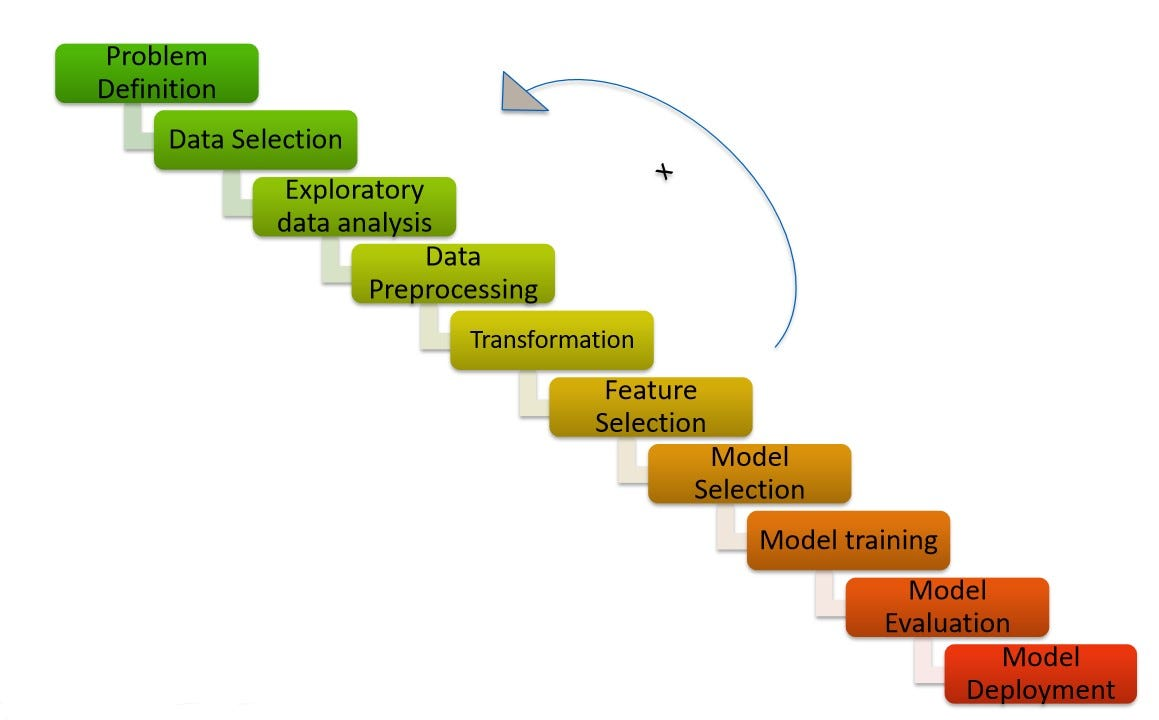

### Exploratory data analysis is done . lets 
# `Prepare the Data for Machine Learning Algorithms`

#  X - features
#  y - label / target



In [14]:
#------------------------------ reload and Sample Data Into Train and Test Datasets--------
housing = pd.read_csv('housing.csv')
y = housing["median_house_value"]
X = housing.drop("median_house_value",axis=1)

In [15]:
#-----------------------data sampling--------------------------------------------
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=111)

#--------------feature selection for data preprocessing --------------------------------
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
nominal_features = ['ocean_proximity']

* <p style='color:violet'> seperate pipelines will be made to process categorical and numerical features.</p>


In [16]:
#making a custom tranformer to add new columns . 
from sklearn.base import BaseEstimator,TransformerMixin
#column index number of features
total_rooms, total_bedrooms, population, households = 3, 4, 5, 6
class FeatureAdder(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, total_rooms] / X[:, households]
        population_per_household = X[:, population] / X[:, households]
        bedrooms_per_room = X[:, total_bedrooms] / X[:, total_rooms]
        return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
    
        

In [17]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('feature_add',FeatureAdder()),
    ])
#first 9 columns are of dataframe . then 3 new columns , then 5 encoded column
pipeline = ColumnTransformer([
    ('num_pipeline',num_pipeline,num_features),
    ('nominal_pipeline',OneHotEncoder(),nominal_features)
])

# x train transform 
X_train_tr = pipeline.fit_transform(X_train)  # learn from training data. (missing value etc)
X_test_tr = pipeline.transform(X_test) # (apply to test data.)

#scaling 
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train_tr)
X_test_tr = scaler.transform(X_test_tr)

In [18]:
# test linear regression model to predict median house value . 
lin_model = LinearRegression()
lin_model.fit(X_train_tr,y_train)

LinearRegression()

In [19]:
# predicted label/target 
y_hat_train = lin_model.predict(X_train_tr)
y_hat_test = lin_model.predict(X_test_tr)

In [20]:
#finding r2 score for test and training accuracy . 
train_accuracy = r2_score(y_train,y_hat_train)
test_accuracy = r2_score(y_test,y_hat_test)
print("Train accuracy -> ",  train_accuracy*100,"%")
print("Test accuracy  -> ",  test_accuracy*100,"%")

Train accuracy ->  64.98752158900854 %
Test accuracy  ->  64.81818033590972 %


* **performance measure / cost function** - **root mean square error.**

In [21]:
def rmse(y, y_hat): #root mean squre error.
    mse = mean_squared_error(y, y_hat)
    return np.sqrt(mse)

In [22]:
print(f"Train Error -> {rmse(y_train,y_hat_train):.2f}\n Test Error-> {rmse(y_test,y_hat_test):.2f}")

Train Error -> 68232.08
 Test Error-> 68621.79


<pre style='color:brown'>
<b>Cross-validation</b> is a technique used to evaluate the performance of a machine learning model. It is used to estimate how well a predictive model will perform in practice. The goal of cross-validation is to define a dataset to “test” the model in the training phase (i.e., the validation dataset) in order to limit problems like overfitting, and get an idea of how the model will generalize to an independent dataset.

In cross-validation, a dataset is divided into two or more groups or folds. A model is then trained on one group and tested on another group. This process is repeated until each group has been used as the test data exactly once</pre>

In [23]:
# Cross_validation scores . is a more refined way to check 
scores = cross_val_score(lin_model, X_train_tr, y_train,
                         scoring="neg_mean_squared_error", cv=10)
lin_model_errors = np.sqrt(-scores)
lin_model_errors.mean()

68513.2148577081

In [24]:
# r2 score using cross val technique
scores = cross_val_score(lin_model, X_train_tr, y_train,
                         scoring="r2", cv=10)
scores.mean()*100

64.64834819616343

    the results are nearly similar.

# <span style='color:#1465CC'><ins>We will Train our data with these machine learning model</ins> - </span> 
LinearRegression , SGDRegressor , DecisionTreeRegressor , SVR , RandomForestRegressor 


* **Linear Regression** - Linear regression is a statistical method used to study the relationship between two continuous variables. It is used to predict the value of one variable based on the value of another variable. The goal of linear regression is to find the best-fitting straight line through the points
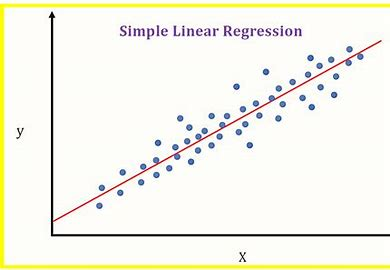

* **SGD regressor** - SGD Regressor is a regularized linear model with Stochastic Gradient Descent (SGD) learning1. It is a plain stochastic gradient descent learning routine that supports different loss functions and penalties to fit linear regression models.


* **DecisionTreeRegressor** - DecisionTreeRegressor is a class in the scikit-learn library for machine learning in Python. It is used to create a decision tree model for regression problems, where the goal is to predict a continuous target variable based on one or more input features

* **SVR** - Support Vector Regression (SVR) is a type of machine learning algorithm used for regression analysis. The goal of SVR is to find a function that approximates the relationship between the input variables and a continuous target variable, while minimizing the prediction error


* **RandomForestRegressor** - RandomForestRegressor is a class in the scikit-learn library for machine learning in Python. It is used to create a random forest model for regression problems, where the goal is to predict a continuous target variable based on one or more input features. A random forest is an ensemble learning method that fits multiple decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

In [25]:
# function to show all model results in one table format.
def train_ml_models(models, X_train_tr, X_test_tr, y_train, y_test):
    result = {"Model Name": [], "Train Accuracy": [], "Test Accuracy": [],
             "Train Error": [], "Test Error": []}
    
    title = "|{:^30}|{:^18}|{:^18}|{:^18}|{:^18}|"
    width = 108
    # model name  train accuracy     test accuracy    train error   test error 
    print("_"*width)
    print(title.format("Model Name", "Train Accuracy %", "Test Accuracy %", "Train Error", "Test Error"))
    print("_"*width)
    for model in models:
        model.fit(X_train_tr, y_train)
        y_hat_train = model.predict(X_train_tr)
        y_hat_test = model.predict(X_test_tr)
        tr_acc = round(r2_score(y_train, y_hat_train)*100, 2)
        ts_acc = round(r2_score(y_test, y_hat_test)*100, 2)
        tr_err = round(rmse(y_train, y_hat_train), 2)
        ts_err = round(rmse(y_test, y_hat_test), 2)
        result["Model Name"].append(model)
        result["Train Accuracy"].append(tr_acc)
        result["Test Accuracy"].append(ts_acc)
        result["Train Error"].append(tr_err)
        result["Test Error"].append(ts_err)
        print(title.format(str(model), tr_acc, ts_acc, tr_err, ts_err))
        print("-"*width)
    return pd.DataFrame(result)


In [26]:
models = [LinearRegression(), SGDRegressor(), DecisionTreeRegressor(), SVR(), RandomForestRegressor()]
result = train_ml_models(models, X_train_tr, X_test_tr, y_train, y_test)

____________________________________________________________________________________________________________
|          Model Name          | Train Accuracy % | Test Accuracy %  |   Train Error    |    Test Error    |
____________________________________________________________________________________________________________
|      LinearRegression()      |      64.99       |      64.82       |     68232.08     |     68621.79     |
------------------------------------------------------------------------------------------------------------
|        SGDRegressor()        |  -1198941051.9   |    -249037.63    |   399278662.45   |    5774608.38    |
------------------------------------------------------------------------------------------------------------
|   DecisionTreeRegressor()    |      100.0       |      61.41       |       0.0        |     71864.92     |
------------------------------------------------------------------------------------------------------------
|            SVR() 

# Hyper parameter tunining

In [27]:
#Grid search cv is the class in sklearn which which is used in hyperparameter tunning
from sklearn.model_selection import GridSearchCV
# we will give different parameter values and gridsearchcv will find best parameter.
param_grid = [
    {
        "max_depth": [1, 3, 5, 7, 9],
        "max_features": [2, 4, 6, 8],
        "n_estimators": [10, 20, 40, 60, 90, 140, 200, 250]
    
    }
]

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest, param_grid, scoring="neg_mean_squared_error")

grid_search.fit(X_train_tr, y_train)
grid_search.best_params_

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_

In [ ]:
# this will random forest regression model with best hyper parameters. 
best_model = grid_search.best_estimator_

In [ ]:
# we will now predict the y hat /target using best model on X train data.
y_hat_train = grid_search.predict(X_train_tr)

#lets check the training accuracy and rmse of best random forest regressor
print("r2 score",r2_score(y_train, y_hat_train)) #r2 score for Train accuracy
print("rmse",rmse(y_train,y_hat_train))# train error

In [ ]:
#predicting y_hat_test/target using X_test_tr data. 
y_hat_test = best_model.predict(X_test_tr)
print("r2 score",r2_score(y_test,y_hat_test)) # r2 score /Test accuracy
print("rmse",rmse(y_test, y_hat_test)) # rmse / test error

__we will use best model which has highest test accuracy and low test error.__

-----------------------completed-------------------------------------------------------